Mesh generation using diff point distribution.


In [17]:
# General and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.tri as tri

# Random sampling and Poisson disk sampling
from scipy.stats import qmc
from scipy.spatial import Delaunay

# semiuniform sampling
import pyvista as pv
import tetgen

#Uniform sampling
import meshzoo


def plot_pyvista(nodes, simplices):
    buf = np.empty((len(simplices), 1), pv.ID_TYPE)
    buf[:] = 4
    elements = np.hstack((buf, simplices))
    elements = elements.flatten()
    cell_type = np.empty(len(simplices), dtype='uint8')
    cell_type[:] = 10

    grid = pv.UnstructuredGrid(elements, cell_type, nodes)
    #grid = tgen.grid

    # get cell centroid
    
    #esta linea es maldita
    #cambia la dimension de los elementos de 1d a 2d n,5.
    # los copia al arreglo cells y le saca primera columna que corresponde al número de vértices
    cells = grid.cells.reshape(-1, 5)[:, 1:]
    #esta wea dado los indices de los vértices de cada celda,
    #obtiene las coordenadas de los vértices y calcula su promedio
    cell_center = grid.points[cells].mean(1)

    # extract cells below the 0 xy plane
    mask = cell_center[:, 2] < 0.5
    cell_ind = mask.nonzero()[0]
    subgrid = grid.extract_cells(cell_ind)
    # advanced plotting
    plotter = pv.Plotter(notebook=True)
    plotter.background_color = 'white'
    plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
    plotter.add_mesh(pv.Cube(center=(0.5, 0.5, 0.5)), 'r', 'wireframe')
    #plotter.add_legend([[' Input Mesh ', 'r'], [' Tessellated Mesh ', 'black']])
    plotter.show(jupyter_backend='static')

#Move a point to the boundary of the box if the distante to the boundary is less than tolerance
def move_point(max_number, xPoint , yPoint, zPoint, tolerance):
    r =  np.random.uniform(0, 1)
    n = max_number
    # A esta wea la faltan dos casos,pero no sé me ocurren como hacerlo ahora
    if r <= 0.5:
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord
        if zPoint <= max_number*tolerance:
            zPoint = 0
    else:
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0            
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord  
        if zPoint <= max_number*tolerance:
            zPoint = 0
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        

    #print("returning", xPoint, yPoint)
    return (xPoint, yPoint, zPoint)

def add_box(arr, tolerance):
    box = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
    arr = np.append(arr, box, axis=0)
    np.unique(arr, axis=0)
    #maxNumber = max(max(arr[:,0]), max(arr[:,1]), max(arr[:,2]))
    for i in range(0, len(arr)):
        new_p = move_point(1, arr[i,0], arr[i,1], arr[i,2], tolerance)
        arr[i,0] = new_p[0]
        arr[i,1] = new_p[1]
        arr[i,2] = new_p[2]
    return arr

In [18]:
# 500
tolerance = 0.1 # max distance from the boundary
numVertices = 500 #Random points
radius = 0.105 #Poisson
areaMax = 0.0008 #Semiuniform
lnspace = 8 # Uniform sqrt(500)

## Generate random points

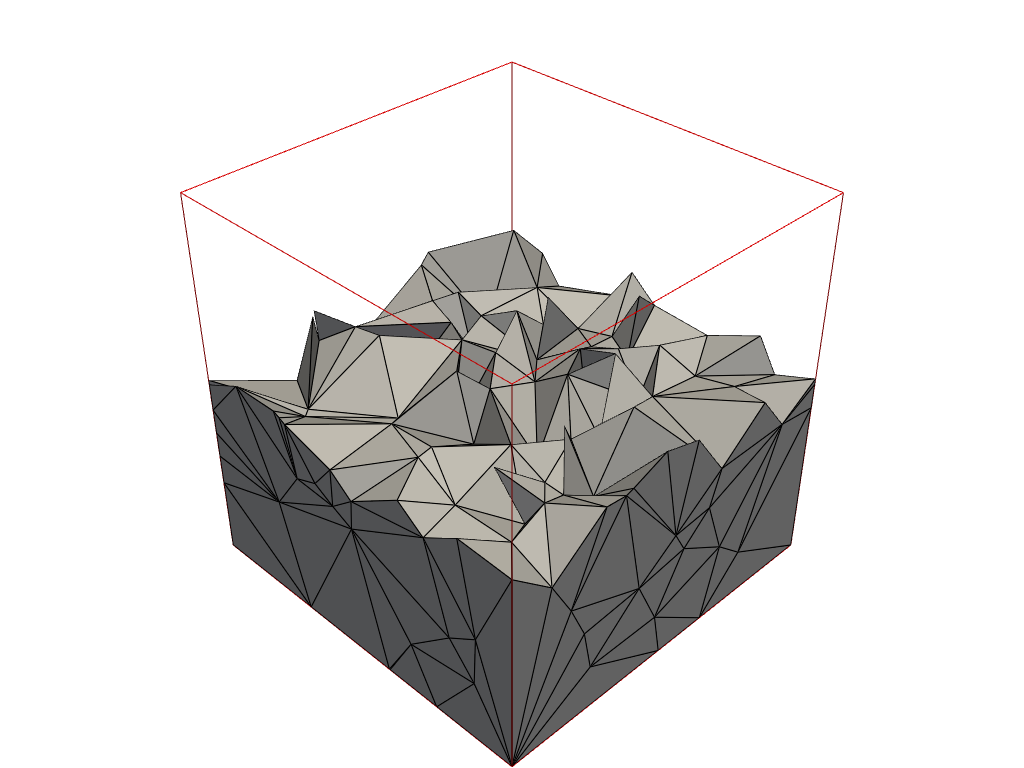

500


In [19]:
RandomSample = np.random.rand(numVertices - 8,3)
RandomSample = add_box(RandomSample, tolerance)

randomDelaunay = Delaunay(RandomSample)

plot_pyvista(randomDelaunay.points , randomDelaunay.simplices)

print(len( randomDelaunay.points))

# Generate poisson points

Number of points:  544


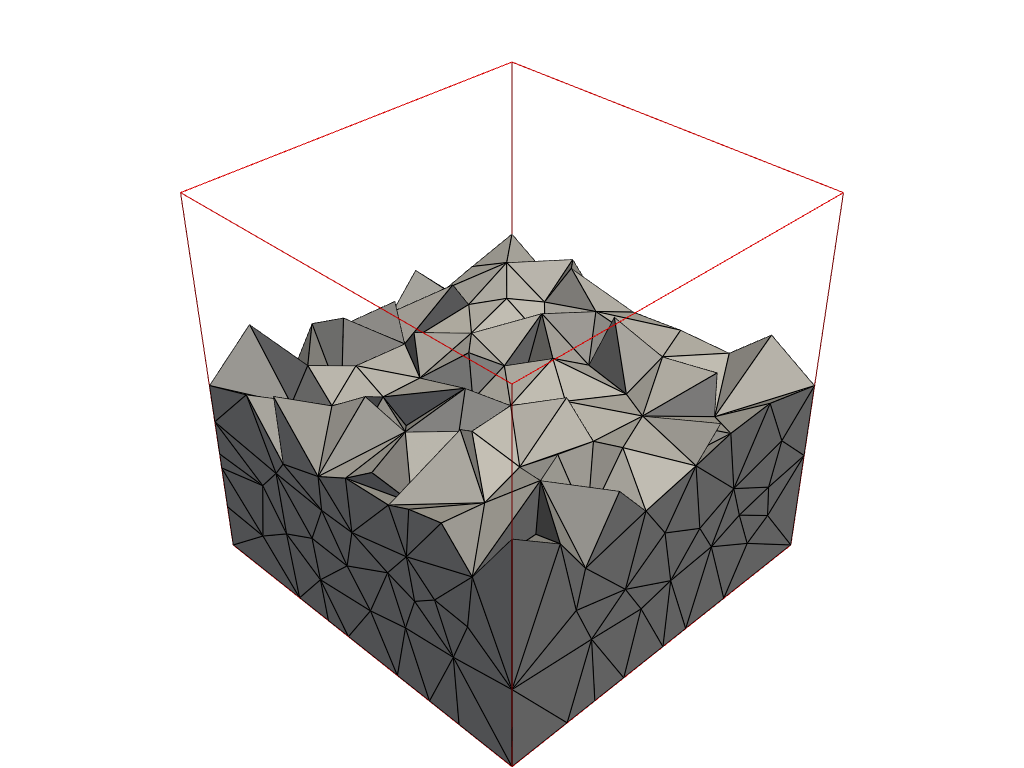

In [20]:
rng = np.random.default_rng()
engine = qmc.PoissonDisk(d=3, radius=radius, seed=rng)
sample = engine.fill_space()

sample = add_box(sample, tolerance)
poissonTriangulation = Delaunay(sample)

poissonPoints = sample
poissonTriangles = poissonTriangulation.simplices.copy()

print("Number of points: ", len(poissonPoints))
plot_pyvista(poissonPoints, poissonTriangulation.simplices)

## Simiuniform mesh

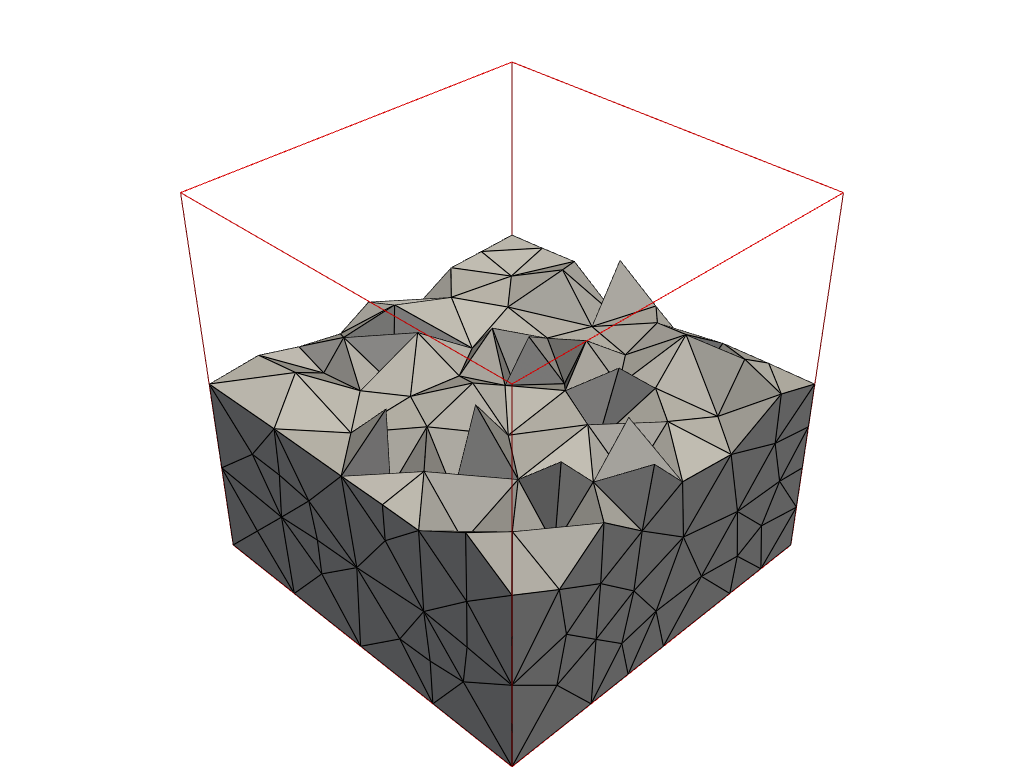

number of simplices:  514


In [21]:
v = np.array([[0, 0, 0], [1, 0, 0],
                  [1, 1, 0], [0, 1, 0],
                  [0, 0, 1], [1, 0, 1],
                  [1, 1, 1], [0, 1, 1],])
f = np.vstack([[0, 1, 2], [2, 3, 0],
                   [0, 1, 5], [5, 4, 0],
                   [1, 2, 6], [6, 5, 1],
                   [2, 3, 7], [7, 6, 2],
                   [3, 0, 4], [4, 7, 3],
                   [4, 5, 6], [6, 7, 4]])
tgen = tetgen.TetGen(v, f)
SemiUniformPoints, SemiUniformTriangles = tgen.tetrahedralize(switches="pqa" + str(areaMax))
plot_pyvista(SemiUniformPoints, SemiUniformTriangles)
print("number of simplices: ", len(SemiUniformPoints))

## Uniform grid

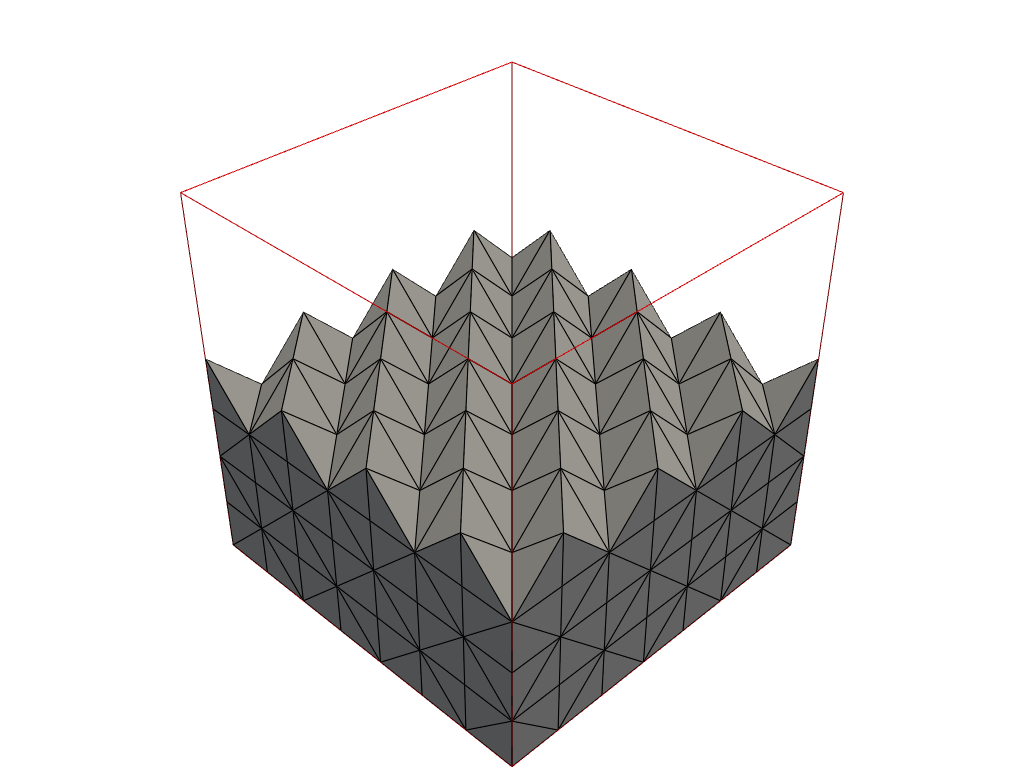

Number of points:  512


In [22]:

import meshzoo
UniformPoints, UniformTriangles = meshzoo.cube_tetra(
    np.linspace(0.0, 1.0, lnspace), np.linspace(0.0, 1.0, lnspace), np.linspace(0.0, 1.0, lnspace)
)

plot_pyvista(UniformPoints, UniformTriangles)

print("Number of points: ", len(UniformPoints))


# Generate mesh files

In [23]:
#Num of vertices and simplices
print(len(randomDelaunay.points), len(randomDelaunay.simplices))
print(len(poissonPoints), len(poissonTriangles))
print(len(SemiUniformPoints), len(SemiUniformTriangles))
print(len(UniformPoints), len(UniformTriangles))


import meshio
#writte .node files
meshio.write_points_cells(str(numVertices) + "random.node", randomDelaunay.points, [("tetra", randomDelaunay.simplices)])
meshio.write_points_cells(str(numVertices) + "poisson.node", poissonPoints, [("tetra", poissonTriangles)])
meshio.write_points_cells(str(numVertices) + "semiuniform.node", SemiUniformPoints, [("tetra", SemiUniformTriangles)])
meshio.write_points_cells(str(numVertices) + "uniform.node", UniformPoints, [("tetra", UniformTriangles)])



500 2399
544 2399
514 2192
512 1715


## Call to tetgen

In [27]:
import os

os.system("tetgen.exe -fzenn " + str(numVertices) + "random.node")
os.system("tetgen.exe -fzenn " + str(numVertices) + "poisson.node")
os.system("tetgen.exe -fzenn " + str(numVertices) + "semiuniform.node")
os.system("tetgen.exe -fzenn " + str(numVertices) + "uniform.node")

0